# Crime Data in LA (2010-2019)
### Pyspark EDA

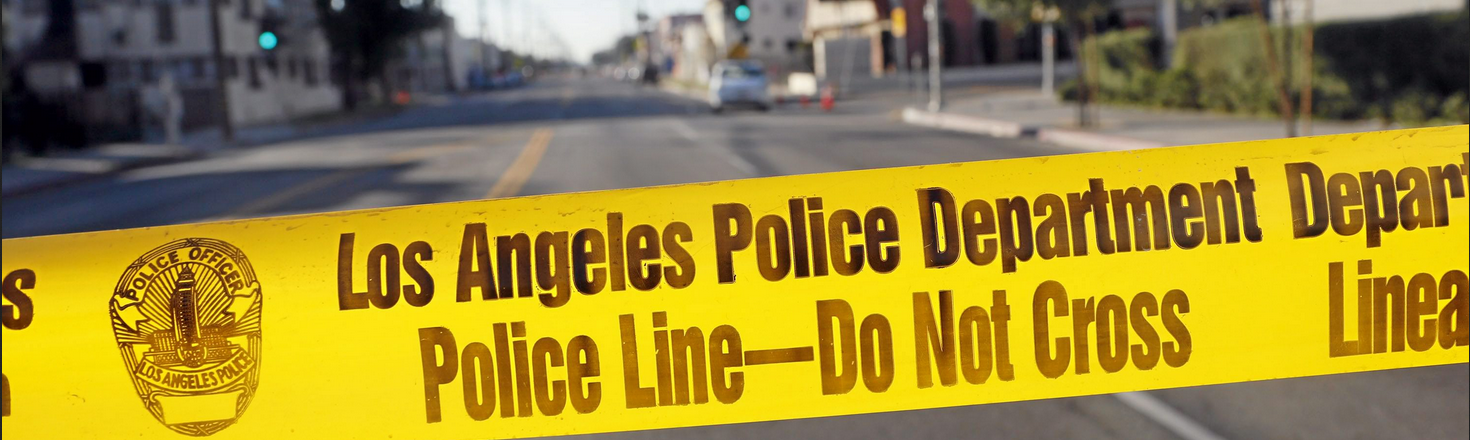

**Datasource:** 
- https://www.kaggle.com/chaitanyakck/crime-data-from-2020-to-present?select=Crime_Data_from_2020_to_Present.csv

**Original Datasource incl. Descriptions:** 
- Metadata: https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
- Data: https://catalog.data.gov/dataset/crime-data-from-2010-to-2019

## Contents
**PART I: Preparation** 
1. PySpark Environment SetUp
2. Importing Dataset
3. Data Preparation
- Time Data
- Location Data
- Crime Data
- Victim Data

**Part II: Business Analysis**
1. How has crime developed over time
2. Who are the victims
3. Where are crimes happening
4. When are crimes occuring
5. How much time passes between a crime occuring and being reported

**PART III** 
1. Saving results

## 1. PySpark environment setup

In [1]:
import findspark
findspark.init()

In [2]:
#### Adapt frame size manually (witdh:x%)
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

In [3]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder\
            .appName("LA Crime Analysis")\
            .getOrCreate()

In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

## 2. Import Dataset

In [5]:
df = spark.read.option("inferSchema", "true")\
            .option("header", "true")\
            .csv("Crime_Data_from_2010_to_2019.csv")\
            .cache()

df.printSchema()

# make a copy of the data
crime=df

root
 |-- DR_NO: integer (nullable = true)
 |-- Date Rptd: string (nullable = true)
 |-- DATE OCC: string (nullable = true)
 |-- TIME OCC: integer (nullable = true)
 |-- AREA : integer (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- Rpt Dist No: integer (nullable = true)
 |-- Part 1-2: integer (nullable = true)
 |-- Crm Cd: integer (nullable = true)
 |-- Crm Cd Desc: string (nullable = true)
 |-- Mocodes: string (nullable = true)
 |-- Vict Age: integer (nullable = true)
 |-- Vict Sex: string (nullable = true)
 |-- Vict Descent: string (nullable = true)
 |-- Premis Cd: integer (nullable = true)
 |-- Premis Desc: string (nullable = true)
 |-- Weapon Used Cd: integer (nullable = true)
 |-- Weapon Desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status Desc: string (nullable = true)
 |-- Crm Cd 1: integer (nullable = true)
 |-- Crm Cd 2: integer (nullable = true)
 |-- Crm Cd 3: integer (nullable = true)
 |-- Crm Cd 4: integer (nullable = true)
 |-- 

In [6]:
# Analyze random sample of the dataset
display(crime.sample(0.1).take(1))

[Row(DR_NO=100100553, Date Rptd='01/23/2010 12:00:00 AM', DATE OCC='01/23/2010 12:00:00 AM', TIME OCC=1100, AREA =1, AREA NAME='Central', Rpt Dist No=166, Part 1-2=1, Crm Cd=210, Crm Cd Desc='ROBBERY', Mocodes='0344 0416', Vict Age=50, Vict Sex='M', Vict Descent='W', Premis Cd=101, Premis Desc='STREET', Weapon Used Cd=400, Weapon Desc='STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)', Status='IC', Status Desc='Invest Cont', Crm Cd 1=210, Crm Cd 2=None, Crm Cd 3=None, Crm Cd 4=None, LOCATION='600    SAN JULIAN                   ST', Cross Street=None, LAT=34.0428, LON=-118.2461)]

In [88]:
# Clean up column names

# Define a function to replace whitespace with underscore and rename the id column
def rename(column):
        return column.replace(' ', '_').lower()

# Renaming columns
crime = crime.select([col("`" + c + "`").alias(rename(c)) for c in crime.columns])

In [89]:
crime.printSchema()

root
 |-- crm_cd: integer (nullable = true)
 |-- dr_no: integer (nullable = true)
 |-- date_rptd: string (nullable = true)
 |-- date_occ: string (nullable = true)
 |-- time_occ: string (nullable = false)
 |-- area_: integer (nullable = true)
 |-- area_name: string (nullable = true)
 |-- rpt_dist_no: integer (nullable = true)
 |-- part_1-2: integer (nullable = true)
 |-- crm_cd_desc: string (nullable = true)
 |-- vict_age: integer (nullable = true)
 |-- vict_sex: string (nullable = false)
 |-- vict_descent: string (nullable = false)
 |-- premis_cd: integer (nullable = true)
 |-- premis_desc: string (nullable = false)
 |-- weapon_used_cd: integer (nullable = true)
 |-- weapon_desc: string (nullable = false)
 |-- status: string (nullable = false)
 |-- status_desc: string (nullable = false)
 |-- crm_cd_1: integer (nullable = true)
 |-- crm_cd_2: integer (nullable = true)
 |-- crm_cd_3: integer (nullable = true)
 |-- crm_cd_4: integer (nullable = true)
 |-- location: string (nullable = true

In [9]:
# Dropping Duplicates in case there are duplicate rows
crime.dropDuplicates()

DataFrame[dr_no: int, date_rptd: string, date_occ: string, time_occ: int, area_: int, area_name: string, rpt_dist_no: int, part_1-2: int, crm_cd: int, crm_cd_desc: string, mocodes: string, vict_age: int, vict_sex: string, vict_descent: string, premis_cd: int, premis_desc: string, weapon_used_cd: int, weapon_desc: string, status: string, status_desc: string, crm_cd_1: int, crm_cd_2: int, crm_cd_3: int, crm_cd_4: int, location: string, cross_street: string, lat: double, lon: double]

In [10]:
crime.count()

2116239

The dataset contains 2,116,239 rows

## 3. Preparing the Data

### 3.1. Time Data

In [11]:
# Checking for null values
print("Checking for nulls:")
crime.select([count(when(col(c).isNull(), c)).alias(c) for c in ["date_rptd", "date_occ", "time_occ"]]).show()

Checking for nulls:
+---------+--------+--------+
|date_rptd|date_occ|time_occ|
+---------+--------+--------+
|        0|       0|       0|
+---------+--------+--------+



In [12]:
# Get data type
print("Get data types:")
crime.select("date_rptd", "date_occ", "time_occ").dtypes

Get data types:


[('date_rptd', 'string'), ('date_occ', 'string'), ('time_occ', 'int')]

In [13]:
# Observe date variables closer in order to transform from string to date types
crime.select("date_rptd", "date_occ").show(2,False)

+----------------------+----------------------+
|date_rptd             |date_occ              |
+----------------------+----------------------+
|02/20/2010 12:00:00 AM|02/20/2010 12:00:00 AM|
|09/13/2010 12:00:00 AM|09/12/2010 12:00:00 AM|
+----------------------+----------------------+
only showing top 2 rows



In [14]:
# Transforming to date types   
crime=crime.withColumn("date_reported", to_timestamp("date_rptd","MM/dd/yyyy hh:mm:ss a"))\
            .withColumn("date_reported", col("date_reported").cast("date"))
                        
crime=crime.withColumn("date_occured", to_timestamp("date_occ","MM/dd/yyyy hh:mm:ss a"))\
            .withColumn("date_occured", col("date_occured").cast("date"))

crime.select("date_reported","date_occured").show()
crime.select("date_reported","date_occured").dtypes


+-------------+------------+
|date_reported|date_occured|
+-------------+------------+
|   2010-02-20|  2010-02-20|
|   2010-09-13|  2010-09-12|
|   2010-08-09|  2010-08-09|
|   2010-01-05|  2010-01-05|
|   2010-01-03|  2010-01-02|
|   2010-01-05|  2010-01-04|
|   2010-01-08|  2010-01-07|
|   2010-01-09|  2010-01-08|
|   2010-01-09|  2010-01-09|
|   2010-01-09|  2010-01-06|
|   2010-01-14|  2010-01-14|
|   2010-01-15|  2010-01-14|
|   2010-01-15|  2010-01-15|
|   2010-01-16|  2010-01-15|
|   2010-01-16|  2010-01-15|
|   2010-01-17|  2010-01-16|
|   2010-01-23|  2010-01-23|
|   2010-01-23|  2010-01-23|
|   2010-01-23|  2010-01-23|
|   2010-01-26|  2010-01-26|
+-------------+------------+
only showing top 20 rows



[('date_reported', 'date'), ('date_occured', 'date')]

In [15]:
# Count distinct values for each variable
print("Number of distinct values per variable:")
crime.agg(*(countDistinct(col(c)).alias(c) for c in ["date_reported", "date_occured", "time_occ"])).show()

Number of distinct values per variable:
+-------------+------------+--------+
|date_reported|date_occured|time_occ|
+-------------+------------+--------+
|         3996|        3652|    1439|
+-------------+------------+--------+



In [16]:
# Date occured
# Create new variables
# from pyspark.sql.functions import year, month, dayofmonth, dayofweek, date_format

# New Date Variables
crime = crime.withColumn("occ_year", year("date_occured"))
crime = crime.withColumn("occ_month", month("date_occured"))
crime = crime.withColumn("occ_dayofmonth", dayofmonth("date_occured"))
crime = crime.withColumn("occ_dayofweek", dayofweek("date_occured"))
crime = crime.withColumn("occ_weekday", date_format("date_occured","E"))

# Analyze newly created date variables
crime.select("date_occured", "occ_year", "occ_month", "occ_dayofmonth", "occ_dayofweek","occ_weekday").show(3) 

+------------+--------+---------+--------------+-------------+-----------+
|date_occured|occ_year|occ_month|occ_dayofmonth|occ_dayofweek|occ_weekday|
+------------+--------+---------+--------------+-------------+-----------+
|  2010-02-20|    2010|        2|            20|            7|        Sat|
|  2010-09-12|    2010|        9|            12|            1|        Sun|
|  2010-08-09|    2010|        8|             9|            2|        Mon|
+------------+--------+---------+--------------+-------------+-----------+
only showing top 3 rows



In [17]:
# Date reported
# Create new variables
# from pyspark.sql.functions import year, month, dayofmonth, dayofweek, date_format

# New Date Variables
crime = crime.withColumn("rptd_year", year("date_reported"))
crime = crime.withColumn("rptd_month", month("date_reported"))
crime = crime.withColumn("rptd_dayofmonth", dayofmonth("date_reported"))
crime = crime.withColumn("rptd_dayofweek", dayofweek("date_reported"))
crime = crime.withColumn("rptd_weekday", date_format("date_reported","E"))

# Analyze newly created date variables
#crime.select("date_reported", "rptd_year", "rptd_month", "rptd_dayofmonth", "rptd_dayofweek","rptd_weekday").show() 

### 3.2 Location Data

In [18]:
# Checking for null values
print("Checking for nulls:")
crime.select([count(when(col(c).isNull(), c)).alias(c) for c in ["area_","area_name","rpt_dist_no","location","cross_street", "lat","lon"]]).show()

Checking for nulls:
+-----+---------+-----------+--------+------------+---+---+
|area_|area_name|rpt_dist_no|location|cross_street|lat|lon|
+-----+---------+-----------+--------+------------+---+---+
|    0|        0|          0|       0|     1760810|  0|  0|
+-----+---------+-----------+--------+------------+---+---+



In [19]:
# Drop cross-street
crime = crime.drop(col("cross_street"))

In [20]:
# Get data type
print("Get data types:")
crime.select("area_","area_name","rpt_dist_no","location","lat","lon").dtypes

Get data types:


[('area_', 'int'),
 ('area_name', 'string'),
 ('rpt_dist_no', 'int'),
 ('location', 'string'),
 ('lat', 'double'),
 ('lon', 'double')]

In [21]:
# Count distinct values for each variable
print("Number of distinct values per variable:")
crime.agg(*(countDistinct(col(c)).alias(c) for c in ["area_","area_name","rpt_dist_no","location","lat","lon"])).show()

Number of distinct values per variable:
+-----+---------+-----------+--------+----+----+
|area_|area_name|rpt_dist_no|location| lat| lon|
+-----+---------+-----------+--------+----+----+
|   21|       21|       1303|   75413|5427|5094|
+-----+---------+-----------+--------+----+----+



### 3.3 Crime Data

In [22]:
# Checking for null values
print("Checking for nulls:")
crime.select([count(when(col(c).isNull(), c))\
              .alias(c) for c in ["dr_no", "crm_cd", "crm_cd_desc", "premis_cd", "premis_desc","weapon_used_cd","weapon_desc","status","status_desc","crm_cd_1","crm_cd_2", "crm_cd_3","crm_cd_4"]]).show()

Checking for nulls:
+-----+------+-----------+---------+-----------+--------------+-----------+------+-----------+--------+--------+--------+--------+
|dr_no|crm_cd|crm_cd_desc|premis_cd|premis_desc|weapon_used_cd|weapon_desc|status|status_desc|crm_cd_1|crm_cd_2|crm_cd_3|crm_cd_4|
+-----+------+-----------+---------+-----------+--------------+-----------+------+-----------+--------+--------+--------+--------+
|    0|     0|          0|       53|        187|       1405421|    1405422|     3|          0|      10| 1976631| 2112732| 2116135|
+-----+------+-----------+---------+-----------+--------------+-----------+------+-----------+--------+--------+--------+--------+



In [23]:
# Get data type
print("Get data types:")
crime.select("dr_no", "crm_cd", "crm_cd_desc", "premis_cd", "premis_desc","weapon_used_cd","weapon_desc","status","status_desc","crm_cd_1","crm_cd_2", "crm_cd_3","crm_cd_4").dtypes

Get data types:


[('dr_no', 'int'),
 ('crm_cd', 'int'),
 ('crm_cd_desc', 'string'),
 ('premis_cd', 'int'),
 ('premis_desc', 'string'),
 ('weapon_used_cd', 'int'),
 ('weapon_desc', 'string'),
 ('status', 'string'),
 ('status_desc', 'string'),
 ('crm_cd_1', 'int'),
 ('crm_cd_2', 'int'),
 ('crm_cd_3', 'int'),
 ('crm_cd_4', 'int')]

In [24]:
# Filling null values with "none"
# Categorical Variables
crime = crime.fillna("None",("premis_desc","weapon_desc","status","status_desc"))

# Numerical Variables
crime = crime.fillna(-9999,("premis_cd","weapon_used_cd","crm_cd_1","crm_cd_2","crm_cd_3","crm_cd_4"))

In [25]:
# Drop crime_codes 3 & 4
#crime = crime.drop(col("crm_cd_3","crm_cd_4"))

In [26]:
# Count distinct values for each variable
print("Number of distinct values per variable:")
crime.agg(*(countDistinct(col(c)).alias(c) for c in ["crm_cd", "premis_cd", "weapon_used_cd","status","crm_cd_1","crm_cd_2", "crm_cd_3","crm_cd_4"])).show()

Number of distinct values per variable:
+------+---------+--------------+------+--------+--------+--------+--------+
|crm_cd|premis_cd|weapon_used_cd|status|crm_cd_1|crm_cd_2|crm_cd_3|crm_cd_4|
+------+---------+--------------+------+--------+--------+--------+--------+
|   142|      326|            81|    10|     149|     143|      64|      13|
+------+---------+--------------+------+--------+--------+--------+--------+



In [27]:
# Analyzing in greater detail the top occurences of crime_code_description
print("Distinct values for main variable crime_code_descriptions and number of occurences:")
crime.groupBy("crm_cd_desc").count().orderBy(col("count").desc()).show(20,False)

Distinct values for main variable crime_code_descriptions and number of occurences:
+--------------------------------------------------------+------+
|crm_cd_desc                                             |count |
+--------------------------------------------------------+------+
|BATTERY - SIMPLE ASSAULT                                |190533|
|BURGLARY FROM VEHICLE                                   |162171|
|VEHICLE - STOLEN                                        |159872|
|THEFT PLAIN - PETTY ($950 & UNDER)                      |149848|
|BURGLARY                                                |147686|
|THEFT OF IDENTITY                                       |127529|
|INTIMATE PARTNER - SIMPLE ASSAULT                       |114546|
|VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) |109447|
|ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT          |92714 |
|VANDALISM - MISDEAMEANOR ($399 OR UNDER)                |90430 |
|THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)         |

### 3.4 Victim Data

In [28]:
# Checking for null values
print("Checking for nulls:")
crime.select([count(when(col(c).isNull(), c))\
              .alias(c) for c in ["mocodes", "vict_age", "vict_sex", "vict_descent"]]).show()

Checking for nulls:
+-------+--------+--------+------------+
|mocodes|vict_age|vict_sex|vict_descent|
+-------+--------+--------+------------+
| 228067|       0|  196703|      196749|
+-------+--------+--------+------------+



In [29]:
# Get data type
print("Get data types:")
crime.select("mocodes", "vict_age", "vict_sex", "vict_descent").dtypes

Get data types:


[('mocodes', 'string'),
 ('vict_age', 'int'),
 ('vict_sex', 'string'),
 ('vict_descent', 'string')]

In [30]:
# Filling null values with "none"
# Categorical Variables
crime = crime.fillna("None",("mocodes","vict_sex", "vict_descent"))

In [31]:
# Count distinct values for each variable
print("Number of distinct values per variable:")
crime.agg(*(countDistinct(col(c)).alias(c) for c in ["mocodes", "vict_age", "vict_sex", "vict_descent"])).show()

Number of distinct values per variable:
+-------+--------+--------+------------+
|mocodes|vict_age|vict_sex|vict_descent|
+-------+--------+--------+------------+
| 484654|     110|       7|          21|
+-------+--------+--------+------------+



In [32]:
# Summary Statistics
print("Summary Statistics:")
crime.select("mocodes", "vict_age", "vict_sex", "vict_descent").summary().show()

Summary Statistics:
+-------+-----------------+------------------+--------+------------+
|summary|          mocodes|          vict_age|vict_sex|vict_descent|
+-------+-----------------+------------------+--------+------------+
|  count|          2116239|           2116239| 2116239|     2116239|
|   mean|608.8915071484874|31.762289136529475|    null|        null|
| stddev| 548.766085851971| 20.64775906253001|    null|        null|
|    min|             0100|                -9|       -|           -|
|    25%|            344.0|                20|    null|        null|
|    50%|            344.0|                32|    null|        null|
|    75%|            432.0|                46|    null|        null|
|    max|             None|               118|       X|           Z|
+-------+-----------------+------------------+--------+------------+



In [33]:
# It seems that Vict_age and Vict_Sex require some further analysis

In [34]:
# AGE

#crime.groupBy("vict_age").count().orderBy(col("count").desc()).show(110)

# RESULT: A quick analysis of the age range reveals that there is negative age values, c~400k values with age 0 and 800 with 99+
# We will replace these values with 0 

from pyspark.sql import functions as F

crime=crime.withColumn("vict_age", F.when((col("vict_age")<=0) | (col("vict_age")>=99), 0).otherwise(crime["vict_age"]))

In [35]:
# Disctint counts of victim age
print("Victim Age")
crime.select(("vict_age")).describe().show()

Victim Age
+-------+------------------+
|summary|          vict_age|
+-------+------------------+
|  count|           2116239|
|   mean| 31.72502491448272|
| stddev|20.613919137277982|
|    min|                 0|
|    max|                98|
+-------+------------------+



In [36]:
# Disctint counts of victim sex
print("Victim Sex")
crime.groupBy("vict_sex").count().orderBy(col("count").desc()).show()
# RESULT: we see that there is F=Female, M=Male and X=Unknown as well as several other undefined sex-markers

Victim Sex
+--------+------+
|vict_sex| count|
+--------+------+
|       M|974844|
|       F|889405|
|    None|196703|
|       X| 55196|
|       H|    73|
|       N|    17|
|       -|     1|
+--------+------+



In [37]:
# Change label of unknown sex-categories
crime=crime.withColumn("vict_sex", F.when((col("vict_sex")=="-") | (col("vict_sex")=="H") | (col("vict_sex")=="N") | (col("vict_sex")=="X"), "None").otherwise(crime["vict_sex"]))

In [38]:
# Disctint counts of victim sex after changes
print("Victim Sex")
crime.groupBy("vict_sex").count().orderBy("vict_sex").show()

Victim Sex
+--------+------+
|vict_sex| count|
+--------+------+
|       F|889405|
|       M|974844|
|    None|251990|
+--------+------+



In [39]:
# MOCODE
# The "modus operandi" code describes the nature of the crime, however unfortunately no code translation could be found
# so we drop the variable
crime.groupBy("mocodes").count().orderBy("mocodes").show(10)

# Drop "modus operandi" code
crime = crime.drop(col("mocodes"))

+--------------------+-----+
|             mocodes|count|
+--------------------+-----+
|                0100| 5513|
|      0100 0103 1251|    1|
|           0100 0104|    1|
| 0100 0104 0115 0344|    1|
|0100 0104 0202 03...|    1|
|0100 0104 0202 03...|    1|
| 0100 0104 0202 1402|    1|
| 0100 0104 0304 0344|    1|
|0100 0104 0304 03...|    1|
|0100 0104 0305 03...|    1|
+--------------------+-----+
only showing top 10 rows



In [40]:
# Caching now that we are at the end of our transformations
crime = crime.cache()

In [77]:
# Check partitions: we will not change this given small power of the laptop used
crime.rdd.getNumPartitions()

4

In [41]:
crime.head()

Row(dr_no=1307355, date_rptd='02/20/2010 12:00:00 AM', date_occ='02/20/2010 12:00:00 AM', time_occ=1350, area_=13, area_name='Newton', rpt_dist_no=1385, part_1-2=2, crm_cd=900, crm_cd_desc='VIOLATION OF COURT ORDER', vict_age=48, vict_sex='M', vict_descent='H', premis_cd=501, premis_desc='SINGLE FAMILY DWELLING', weapon_used_cd=-9999, weapon_desc='None', status='AA', status_desc='Adult Arrest', crm_cd_1=900, crm_cd_2=-9999, crm_cd_3=-9999, crm_cd_4=-9999, location='300 E  GAGE                         AV', lat=33.9825, lon=-118.2695, date_reported=datetime.date(2010, 2, 20), date_occured=datetime.date(2010, 2, 20), occ_year=2010, occ_month=2, occ_dayofmonth=20, occ_dayofweek=7, occ_weekday='Sat', rptd_year=2010, rptd_month=2, rptd_dayofmonth=20, rptd_dayofweek=7, rptd_weekday='Sat')

## Part II: Business Analysis

The following questions will be answered:

- How has crime developed over time
- Who are the victims? 
- Where are crimes happening
- When are crimes occuring
- How much time passes between a crime occuring and being reported

### (1) How has crime developed over time

We will analyze how the number of total crimes has developed from 2010 to 2019 and how different crime types have developed over that timeframe. 

#### 1.1 Crime Numbers Overall

In [42]:
# Number of crimes per year 2010-2019
print("Number of crimes per year")
crime_by_year = crime.groupBy(col("occ_year").alias("year")).agg(count("dr_no").alias("Num_reported")).orderBy("occ_year")
crime_by_year.show()

Number of crimes per year
+----+------------+
|year|Num_reported|
+----+------------+
|2010|      209134|
|2011|      200657|
|2012|      201435|
|2013|      192527|
|2014|      195396|
|2015|      215369|
|2016|      225285|
|2017|      230858|
|2018|      228591|
|2019|      216987|
+----+------------+



We observe that in 2013 and 2014 there was a dip in the number of crimes followed by a high in 2017. Since 2017, it appears that crime numbers have been slightly decreasing again. In order to understand whether crime really has been decreasing, let's compare this development of crime numbers to the development of population growth in Los Angeles. 

In [43]:
# Crime rate per 100k Inhabitants: 

# LA Population: Creating dataframe manually with data from https://www2.census.gov/programs-surveys/popest/tables/2010-2019/cities/totals/SUB-IP-EST2019-ANNRNK.xlsx
population = [("2010",3795512),("2011",3820876),("2012",3851202),("2013",3881622),("2014",3909901),("2015",3938568),("2016",3963226),("2017",3975788),("2018",3977596),("2019",3979576)]
popColumns = ["year","population"]

popDF = spark.createDataFrame(data=population, schema = popColumns)
#print("Population of Los Angeles by Year")
#popDF.show(truncate=False)

# Joining the two dataframes and calculating Crime per 100k inhabitants
crime_rate = crime_by_year.join(popDF, "year")\
            .withColumn("CrimePer100k", ceil((col("Num_reported")/(col("population"))*100000)))\
            .orderBy("year")
crime_rate.show()

+----+------------+----------+------------+
|year|Num_reported|population|CrimePer100k|
+----+------------+----------+------------+
|2010|      209134|   3795512|        5511|
|2011|      200657|   3820876|        5252|
|2012|      201435|   3851202|        5231|
|2013|      192527|   3881622|        4960|
|2014|      195396|   3909901|        4998|
|2015|      215369|   3938568|        5469|
|2016|      225285|   3963226|        5685|
|2017|      230858|   3975788|        5807|
|2018|      228591|   3977596|        5747|
|2019|      216987|   3979576|        5453|
+----+------------+----------+------------+



We see now that above mentioned pattern is indeed stable even when controlling for the growth of the population in the same time: crimes had been lower in 2013/2014 before rising again until 2017 and are lower since then.

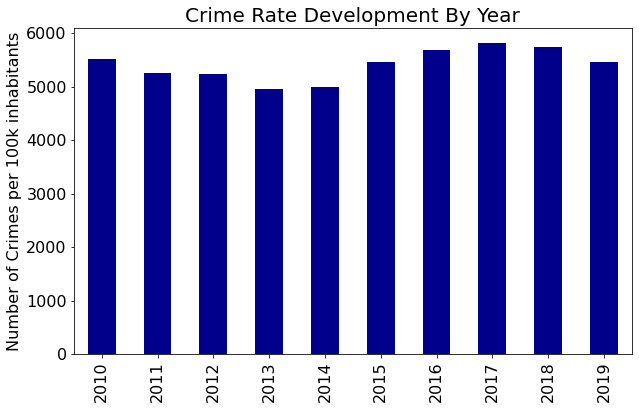

In [44]:
# Visualizing Crime Rate per 100K inhabitants: 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Convert crime rate to a Panda Dataframe
crime_ratePD = crime_rate.toPandas()

# Plot the Crime rate
crime_ratePD.plot(figsize = (10,6), kind = "bar", color = "darkblue",
                               x = "year", y = "CrimePer100k", legend = False)
plt.xlabel("", fontsize = 18)
plt.ylabel("Number of Crimes per 100k inhabitants", fontsize = 16)
plt.title("Crime Rate Development By Year", fontsize = 20)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.show()

#### 1.2 Crime by Type

##### Preparing the Dataset
We have currently 142 crime codes, which describe the crime that occured. We will add additional crime type classifiers which enable us to aggregate the detailed crime codes on several different levels. 
The LA Police Department published* a code system for Part I crimes (Part I Crimes = Violent Crimes + Property Crimes), which further breaks them down into different levels (e.g. Violent Crimes -> Personal Theft -> Pickpocket). Unfortunately, no such classification is given for Part II Crimes (among others Fraud, Embezzlement, Vandalism, Weapons, Prostitution, Drug Abuse, Gambling, DUI, Liquor Laws, Disorderly Conduct, Suspicion, Runaways, etc.) so we will use above classification to differentiate between Part I and Part II crimes and to deeper analzye Part I crimes. We can analyze Part II crimes only on the lowest level using crm_cd_desc (crime code description).

Additionally, we will add growth rates to better understand how crime types have developed over the past few years. 

*https://data.lacity.org/api/views/63jg-8b9z/files/fff2caac-94b0-4ae5-9ca5-d235b19e3c44?download=true&filename=UCR-COMPSTAT062618.pdf

In [45]:
# Importing Crime I classifier (Part I Crimes = Violent Crimes + Property Crimes)

part1crimes = spark.read.option("inferSchema", "true")\
            .option("header", "true")\
            .csv("partI_crimes.csv")\
            .withColumnRenamed("Cl_num","crm_cd")\
            .withColumnRenamed("Cl_desc","Classification_3")\
            .withColumnRenamed("Classification 2","Classification_2")\
            .withColumnRenamed("Classification 1","Classification_1")

print("Schema of newly imported Crime Part I classifier")
part1crimes.printSchema()

# Join Part I classifiers with Crime Table
crime = crime.join(part1crimes,"crm_cd","left_outer")\
            .fillna("Part II Crime",("Classification_1","Classification_2", "Classification_3"))\
            .cache()
    
crime.select("crm_cd", "crm_cd_desc", "Classification_1","Classification_2","Classification_3").show(20,False)

Schema of newly imported Crime Part I classifier
root
 |-- Classification_1: string (nullable = true)
 |-- Classification_2: string (nullable = true)
 |-- crm_cd: integer (nullable = true)
 |-- Classification_3: string (nullable = true)

+------+--------------------------------------------------------+----------------+--------------------------------+--------------------------+
|crm_cd|crm_cd_desc                                             |Classification_1|Classification_2                |Classification_3          |
+------+--------------------------------------------------------+----------------+--------------------------------+--------------------------+
|900   |VIOLATION OF COURT ORDER                                |Part II Crime   |Part II Crime                   |Part II Crime             |
|740   |VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) |Part II Crime   |Part II Crime                   |Part II Crime             |
|946   |OTHER MISCELLANEOUS CRIME              

##### Analyzing Trends by Crime Types

In [46]:
# Aggregation Level 1: Development of Violent crimes vs. Property Crimes vs. Part II Crimes 
print("Development of Crime Types by year (based on Classification 1):")
crime.groupBy("Classification_1").pivot("occ_year").agg(F.count("dr_no"))\
        .withColumn("1y_growth", round((col("2019")/col("2018")-1),2))\
        .withColumn("5y_growth", round((col("2019")/col("2014")-1),2))\
        .withColumn("9y_growth", round((col("2019")/col("2010")-1),2))\
        .orderBy(col("2019").desc())\
        .show()

Development of Crime Types by year (based on Classification 1):
+----------------+-----+-----+-----+-----+-----+-----+-----+------+------+-----+---------+---------+---------+
|Classification_1| 2010| 2011| 2012| 2013| 2014| 2015| 2016|  2017|  2018| 2019|1y_growth|5y_growth|9y_growth|
+----------------+-----+-----+-----+-----+-----+-----+-----+------+------+-----+---------+---------+---------+
| Property Crimes|89678|85944|87512|85465|83335|93621|98982|101615|101367|95013|    -0.06|     0.14|     0.06|
|  Violent Crimes|63134|60199|58734|54816|58900|64094|67252| 70308| 70356|68471|    -0.03|     0.16|     0.08|
|   Part II Crime|56322|54514|55189|52246|53161|57654|59051| 58935| 56868|53503|    -0.06|     0.01|    -0.05|
+----------------+-----+-----+-----+-----+-----+-----+-----+------+------+-----+---------+---------+---------+



We can observe that Property and Violent crimes have been growing strongly in recent years.

In [47]:
# Part I Crimes, Aggregation Level 2: Development of Different crime types 
print("Part I Crimes: Development of Crime Types by year (based on Classification 2):")
graph = crime.filter(col("Classification_2")!="Part II Crime")\
        .groupBy("Classification_1","Classification_2").pivot("occ_year").agg(F.count("dr_no"))\
        .withColumn("1y_growth", round((col("2019")/col("2018")-1),2))\
        .withColumn("5y_growth", round((col("2019")/col("2014")-1),2))\
        .withColumn("9y_growth", round((col("2019")/col("2010")-1),2))\
        .orderBy(col("Classification_1").desc())\
        .show(truncate = False)


# BTFV: burglary or theft from motor vehicle
# GTA: stolen vehicle

Part I Crimes: Development of Crime Types by year (based on Classification 2):
+----------------+----------------------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---------+---------+---------+
|Classification_1|Classification_2                  |2010 |2011 |2012 |2013 |2014 |2015 |2016 |2017 |2018 |2019 |1y_growth|5y_growth|9y_growth|
+----------------+----------------------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---------+---------+---------+
|Violent Crimes  |Agg. Assault - Domestic Violence  |1293 |1270 |1272 |1354 |2034 |3914 |4874 |5655 |5946 |6114 |0.03     |2.01     |3.73     |
|Violent Crimes  |Homicide                          |296  |298  |298  |251  |260  |283  |296  |282  |260  |257  |-0.01    |-0.01    |-0.13    |
|Violent Crimes  |Simple Assault - Domestic Violence|18990|18058|18082|16906|18842|19486|19235|19418|19381|18707|-0.03    |-0.01    |-0.01    |
|Violent Crimes  |Robbery                           |1092

In [48]:
# Part II Crimes, lowest aggregation level (crm_cd_desc): Development of Different crime types 
print("Part II Crimes: Development of Crime Types by year:")
graph = crime.filter(col("Classification_2")=="Part II Crime")\
        .groupBy("crm_cd_desc").pivot("occ_year").agg(F.count("dr_no"))\
        .withColumn("1y_growth", round((col("2019")/col("2018")-1),2))\
        .withColumn("5y_growth", round((col("2019")/col("2014")-1),2))\
        .withColumn("9y_growth", round((col("2019")/col("2010")-1),2))\
        .orderBy(col("2019").desc())\
        .show(10, False)

Part II Crimes: Development of Crime Types by year:
+-------------------------------------------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---------+---------+---------+
|crm_cd_desc                                            |2010 |2011 |2012 |2013 |2014 |2015 |2016 |2017 |2018 |2019 |1y_growth|5y_growth|9y_growth|
+-------------------------------------------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---------+---------+---------+
|VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)|10051|8752 |9036 |8962 |9696 |11586|12768|12953|12804|12839|0.0      |0.32     |0.28     |
|THEFT OF IDENTITY                                      |13225|13435|14350|13438|12790|14988|13411|12454|10566|8872 |-0.16    |-0.31    |-0.33    |
|VANDALISM - MISDEAMEANOR ($399 OR UNDER)               |9941 |10357|9778 |9079 |9105 |8484 |8807 |8832 |8486 |7561 |-0.11    |-0.17    |-0.24    |
|TRESPASSING                                            |141

#### 1.3 By Crime Description (Analyzing trends with Word Analysis)
Another approach to get a quick understanding of different crime categories and events is to use a word analysis. We can do so by counting the frequencies of words appearing in the crm_cd_desc (Crime Code Description) column and displaying the words as a wordcloud to identify recurring patterns/words. 

In [49]:
# Splitting words in column crm_cd_desc and counting their frequency
crime_words = crime.withColumn("word", F.explode(F.split(F.col("crm_cd_desc"), " ")))\
    .groupBy("word")\
    .count()\
    .sort('count', ascending=False)

print("Words used to describe crime committed and their frequency:")
crime_words.show(30)

# Comment: we chose not to use tokenizing here since we will use a stopwords-remover below when creating the wordcloud. 
# Tokenizing would use arrays of words, instead of strings, and is a very common method in text analysis. 
# These tokens help in understanding the context and meaning of a text by analyzing the sequence of the words.

Words used to describe crime committed and their frequency:
+-----------+-------+
|       word|  count|
+-----------+-------+
|          -|1111161|
|    ASSAULT| 522603|
|          &| 501925|
|      THEFT| 477449|
|    VEHICLE| 448475|
|     UNDER)| 391869|
|     SIMPLE| 314388|
|   BURGLARY| 312703|
|      PETTY| 293243|
|      ($950| 287964|
|       FROM| 286681|
|    BATTERY| 207042|
|     STOLEN| 200725|
|  VANDALISM| 199877|
|         OF| 177795|
|      PLAIN| 151506|
|      ($400| 141089|
|     FELONY| 132281|
|   INTIMATE| 129962|
|    PARTNER| 129962|
|   IDENTITY| 127529|
|      MOTOR| 121371|
| AGGRAVATED| 109801|
|        ALL| 109447|
|     CHURCH| 109447|
|VANDALISMS)| 109447|
|      OVER,| 109447|
|       WITH| 105903|
|         OR|  99319|
|    ROBBERY|  95851|
+-----------+-------+
only showing top 30 rows



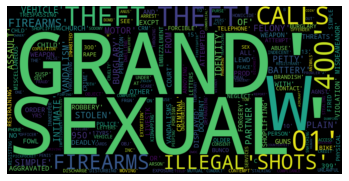

In [50]:
# Creating a Wordcloud 2010-2019

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import matplotlib.pyplot as plt
#%matplotlib inline

# Convert df containing the singled out words into a list
text = list(crime_words.select("word").toPandas()["word"])

# Adding stopwords which shall not appear in the word cloud
stopwords = set(STOPWORDS)
stopwords.add("all")
stopwords.add("$")
stopwords.add("over'")
stopwords.add("at")
stopwords.add("from")
stopwords.add("&")
stopwords.add("with")
stopwords.add("to")

# Creating and Plotting the word cloud
wordcloud = WordCloud(background_color = "black",width = 1000,height = 500,stopwords = stopwords).generate(str(text))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.rcParams["figure.figsize"] = [100, 100]

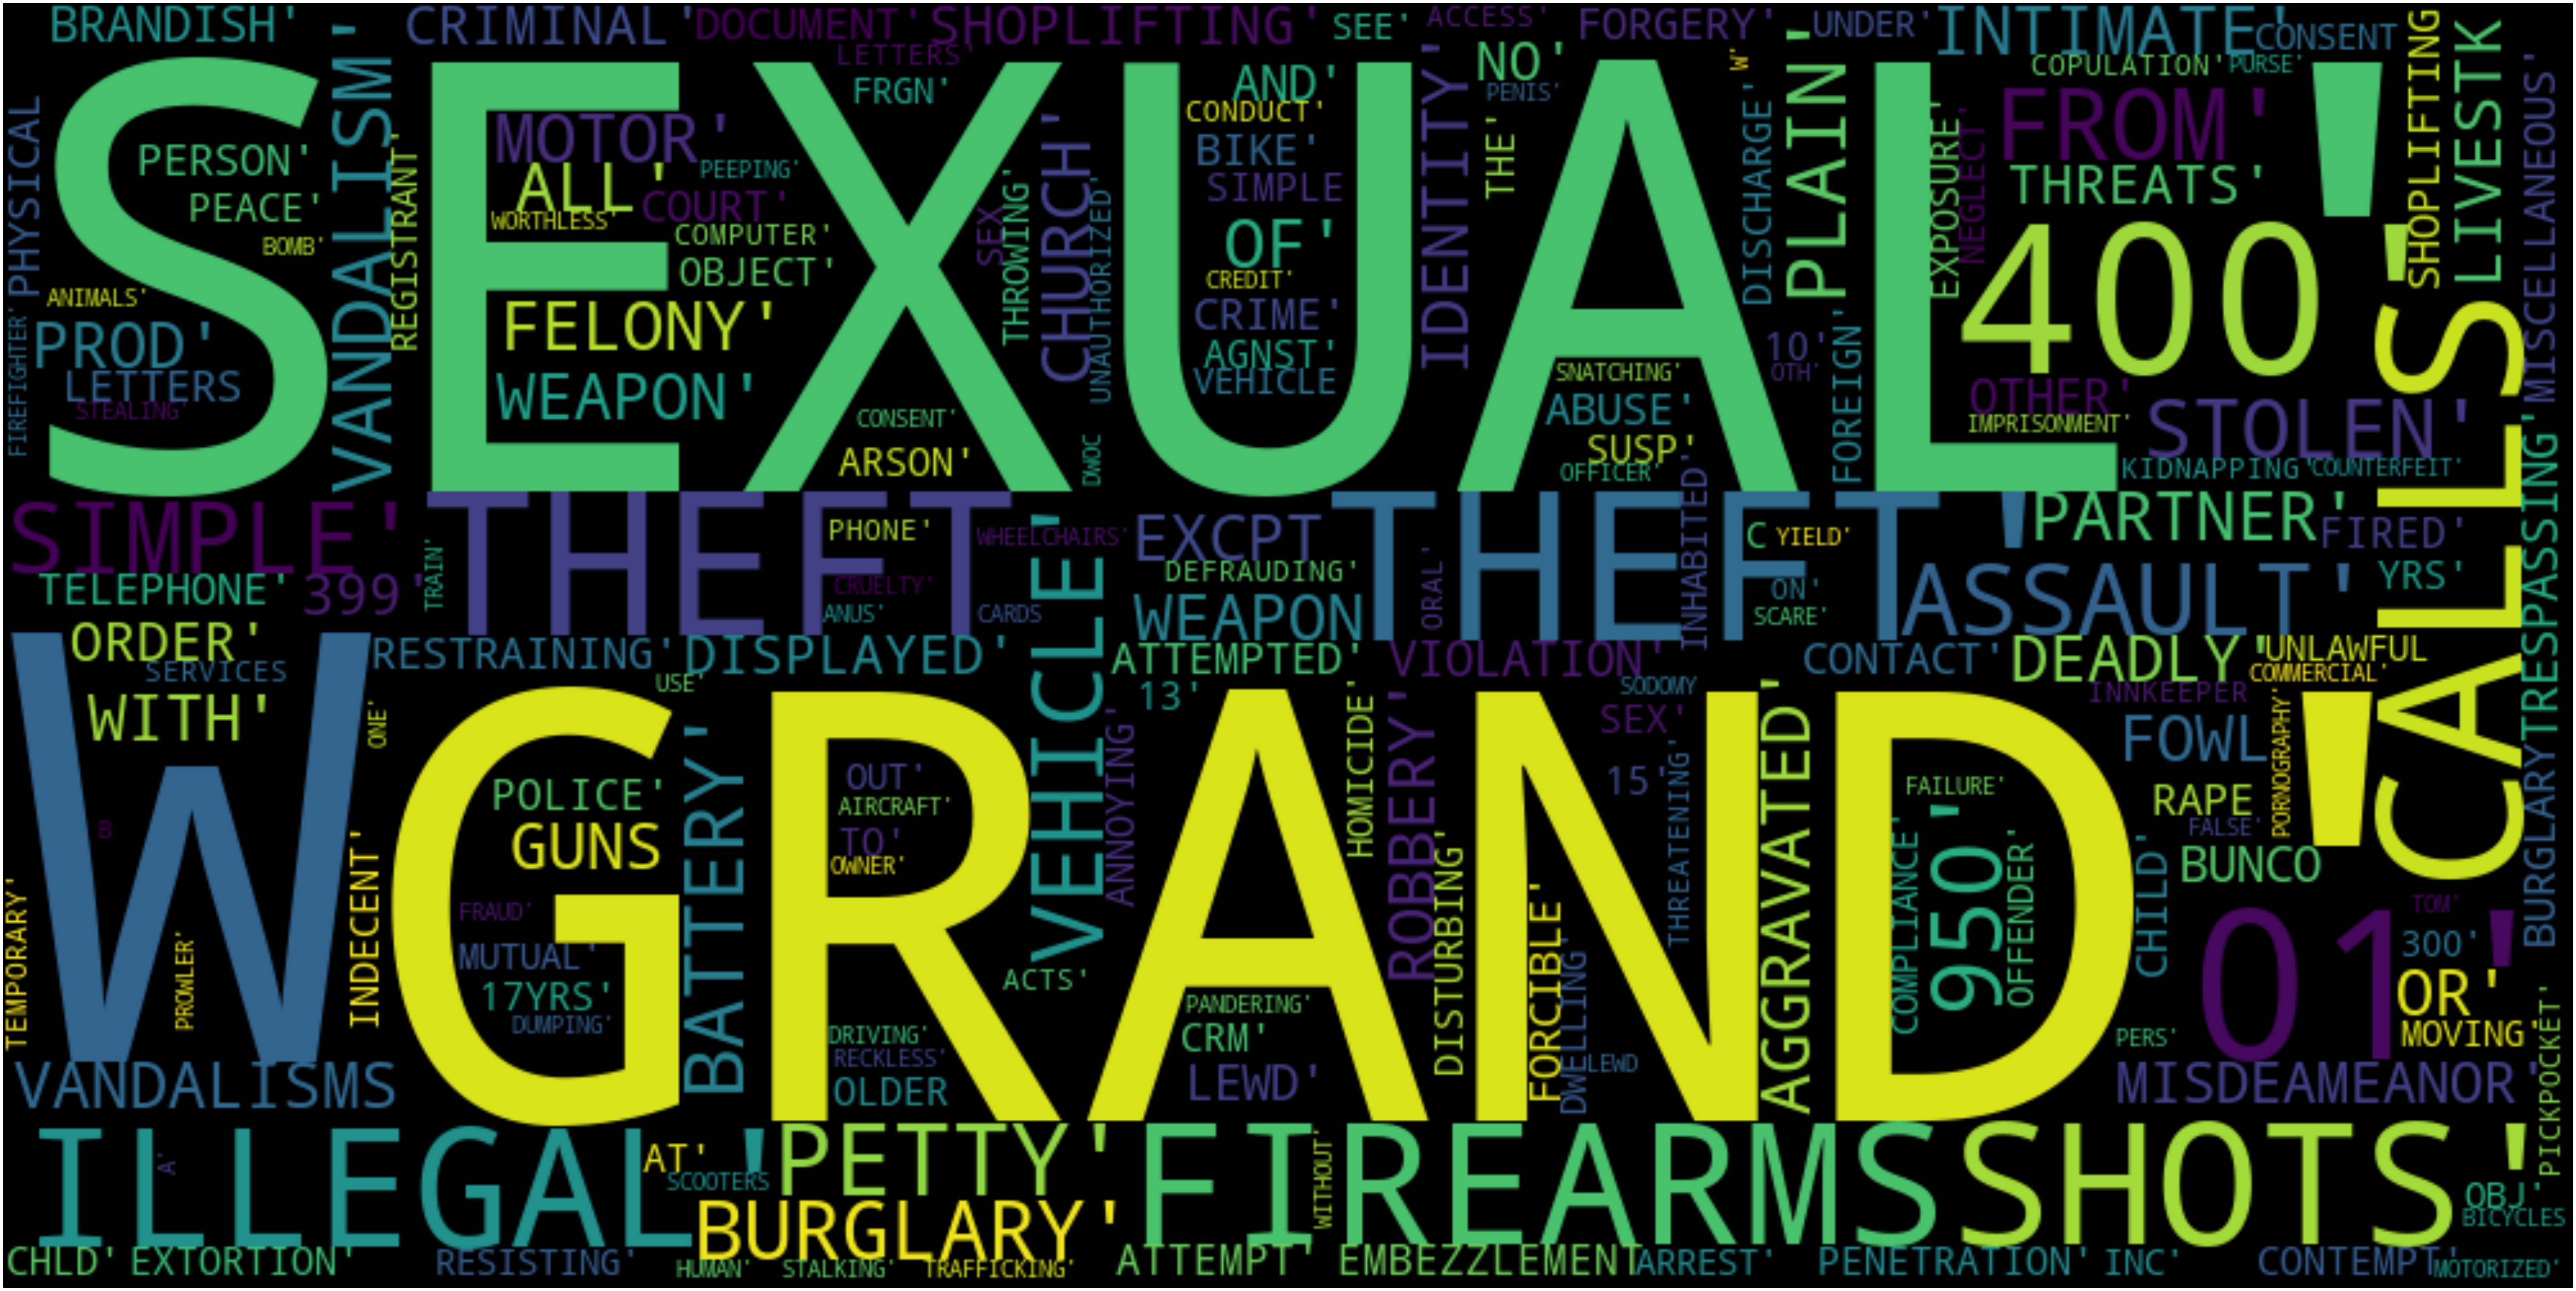

In [51]:
# Word Cloud for 2019 only: 

# Splitting words in column crm_cd_desc and counting their frequency
crime_words_2019 = crime.filter(col("occ_year")=="2019")\
    .withColumn("word", F.explode(F.split(F.col("crm_cd_desc"), " ")))\
    .groupBy("word")\
    .count()\
    .sort('count', ascending=False)



# Convert df containing the singled out words into a list
text_2019 = list(crime_words_2019.select("word").toPandas()["word"])

# Creating and Plotting the word cloud
wordcloud = WordCloud(background_color = "black",width = 1000,height = 500,stopwords = stopwords).generate(str(text_2019))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.rcParams["figure.figsize"] = [100, 100]

In [81]:
plt.rcParams["figure.figsize"] = [10, 10] # for future plots

Both WordClouds (the one for 2010-2019 and the 2019 WordCloud) show a very similar picture. This shows us that the crime landscape in LA has not changed much over time. 

### (2) Who are the Victims

#### 2.1. By Gender

In [52]:
# By Gender #### AS FUNCTION! 
total_2010 = crime.filter(col("occ_year")=="2010").count()
total_2013 = crime.filter(col("occ_year")=="2013").count()
total_2015 = crime.filter(col("occ_year")=="2015").count()
total_2017 = crime.filter(col("occ_year")=="2017").count()
total_2019 = crime.filter(col("occ_year")=="2019").count()

print("Development of the gender of victims):")
crime.groupBy("vict_sex").pivot("occ_year").agg(F.count("dr_no"))\
        .withColumn("5y_abs_growth", round((col("2019")/col("2014")-1),2))\
        .withColumn("9y_abs_growth", round((col("2019")/col("2010")-1),2))\
        .orderBy(col("2019").desc())\
        .show()

print("Development of the gender of victims (abslute and in %)):")
crime.groupBy("vict_sex").pivot("occ_year").agg(F.count("dr_no"))\
        .withColumn("2010_ratio", round(col("2010")/total_2019,2).alias("2010_share"))\
        .withColumn("2013_ratio", round(col("2013")/total_2019,2).alias("2013_share"))\
        .withColumn("2015_ratio", round(col("2015")/total_2019,2).alias("2015_share"))\
        .withColumn("2017_ratio", round(col("2017")/total_2019,2).alias("2017_share"))\
        .withColumn("2019_ratio", round(col("2019")/total_2019,2).alias("2019_share"))\
        .orderBy(col("2019").desc())\
        .show()

Development of the gender of victims):
+--------+-----+-----+-----+-----+-----+------+------+------+------+-----+-------------+-------------+
|vict_sex| 2010| 2011| 2012| 2013| 2014|  2015|  2016|  2017|  2018| 2019|5y_abs_growth|9y_abs_growth|
+--------+-----+-----+-----+-----+-----+------+------+------+------+-----+-------------+-------------+
|       M|98311|94107|94510|90191|91167|100553|102502|104516|102717|96270|         0.06|        -0.02|
|       F|90073|87695|87963|83789|84852| 90495| 92857| 93521| 92164|85996|         0.01|        -0.05|
|    None|20750|18855|18962|18547|19377| 24321| 29926| 32821| 33710|34721|         0.79|         0.67|
+--------+-----+-----+-----+-----+-----+------+------+------+------+-----+-------------+-------------+

Development of the gender of victims (abslute and in %)):
+--------+-----+-----+-----+-----+-----+------+------+------+------+-----+----------+----------+----------+----------+----------+
|vict_sex| 2010| 2011| 2012| 2013| 2014|  2015|  20

In [53]:
# Gender by Crime Types
print("Victims' gender distribution for different Crime types")
crime.filter(col("occ_year")=="2019")\
        .groupBy("Classification_1","Classification_2").pivot("vict_sex").agg(F.count("dr_no"))\
        .orderBy(col("Classification_1").desc())\
        .show(truncate=False)

Victims' gender distribution for different Crime types
+----------------+----------------------------------+-----+-----+-----+
|Classification_1|Classification_2                  |F    |M    |None |
+----------------+----------------------------------+-----+-----+-----+
|Violent Crimes  |Rape                              |1547 |170  |2    |
|Violent Crimes  |Homicide                          |35   |222  |null |
|Violent Crimes  |Simple Assault - Domestic Violence|12598|5955 |154  |
|Violent Crimes  |Agg. Assault                      |2994 |7947 |164  |
|Violent Crimes  |Simple Assault                    |9484 |11075|377  |
|Violent Crimes  |Robbery                           |2715 |5788 |1130 |
|Violent Crimes  |Agg. Assault - Domestic Violence  |3388 |2655 |71   |
|Property Crimes |Other Theft                       |10992|16226|5285 |
|Property Crimes |Personal Theft                    |1250 |819  |13   |
|Property Crimes |MVT (GTA)                         |102  |285  |15312|
|Property

In [54]:
# Gender by Crime Types in % of total crimes
print("Victims' gender distribution for different Crime types (2019, in % of total crimes)")

crime.filter(col("occ_year")=="2019")\
        .groupBy("Classification_1","Classification_2").pivot("vict_sex").agg(round(F.count("dr_no")/total_2019*100,2))\
        .orderBy(col("Classification_1").desc())\
        .show(truncate=False)

Victims' gender distribution for different Crime types (2019, in % of total crimes)
+----------------+----------------------------------+-----+-----+----+
|Classification_1|Classification_2                  |F    |M    |None|
+----------------+----------------------------------+-----+-----+----+
|Violent Crimes  |Rape                              |0.71 |0.08 |0.0 |
|Violent Crimes  |Homicide                          |0.02 |0.1  |null|
|Violent Crimes  |Simple Assault - Domestic Violence|5.81 |2.74 |0.07|
|Violent Crimes  |Agg. Assault                      |1.38 |3.66 |0.08|
|Violent Crimes  |Simple Assault                    |4.37 |5.1  |0.17|
|Violent Crimes  |Robbery                           |1.25 |2.67 |0.52|
|Violent Crimes  |Agg. Assault - Domestic Violence  |1.56 |1.22 |0.03|
|Property Crimes |Other Theft                       |5.07 |7.48 |2.44|
|Property Crimes |MVT (GTA)                         |0.05 |0.13 |7.06|
|Property Crimes |Personal Theft                    |0.58 |0.38 

We observe that while overall men and women seem to be almost equally likely to become a victim of a crime, this ratio differs significantly for different crime types. We observe for 2019 that more often women are victims of domestic violence, rape and homicide than men whereas more often men are victims of aggravated and simple assaults as well as of robberies and most types of theft/burglary or stealing from a vehicle. Further, in the majority of cases of vehicle theft (MVT(GTA)) the gender of the victim is not noted down. Men and women appear to become a victim of a Part II Crimes almost equally often. 

#### 2.1. By Age

In [55]:
# Crime victims by Age: 
print("Development of mean age of victims):")
crime.filter(col("vict_age")!=0)\
        .groupBy("vict_sex").pivot("occ_year").agg(round(F.mean("vict_age"),1))\
        .show()


Development of mean age of victims):
+--------+----+----+----+----+----+----+----+----+----+----+
|vict_sex|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|
+--------+----+----+----+----+----+----+----+----+----+----+
|    None|30.2|12.8|12.9|15.6|17.1|18.6|19.0|18.9|19.0|20.1|
|       F|36.1|36.5|36.8|37.2|37.3|37.9|38.0|38.4|38.6|38.5|
|       M|37.9|38.5|38.9|39.4|39.6|39.9|40.0|40.4|40.5|40.4|
+--------+----+----+----+----+----+----+----+----+----+----+



In [56]:
# Victims' Age by Crime Types
print("Victims' mean, min and max age for different Crime types (2019)")
crime.filter(col("occ_year")=="2019")\
        .filter(col("vict_age")!=0)\
        .groupBy("Classification_1","Classification_2")\
        .agg(round(F.mean("vict_age"),2).alias("mean age"),F.min("vict_age").alias("min age"),F.max("vict_age").alias("max age") )\
        .orderBy(col("Classification_1").desc())\
        .show(truncate=False)

Victims' mean, min and max age for different Crime types (2019)
+----------------+----------------------------------+--------+-------+-------+
|Classification_1|Classification_2                  |mean age|min age|max age|
+----------------+----------------------------------+--------+-------+-------+
|Violent Crimes  |Rape                              |28.63   |2      |86     |
|Violent Crimes  |Agg. Assault - Domestic Violence  |36.41   |2      |93     |
|Violent Crimes  |Homicide                          |36.28   |2      |84     |
|Violent Crimes  |Simple Assault                    |39.72   |2      |98     |
|Violent Crimes  |Agg. Assault                      |36.94   |2      |97     |
|Violent Crimes  |Simple Assault - Domestic Violence|34.6    |2      |97     |
|Violent Crimes  |Robbery                           |35.84   |4      |95     |
|Property Crimes |Other Theft                       |39.19   |2      |98     |
|Property Crimes |Personal Theft                    |37.73   |3    

We observe that on average, victims of different crime types are in an age range between their 30s and 40s with rape victims being on average 29 years old. Let's have a look at crime figures specifically for children and young adults:   

In [57]:
# Analyzing victims: adults vs children vs teenagers (2019)

# Defining age categories (excluding 0s since placeholder for "No age given")
age_categories = crime.where(col("occ_year")==2019)\
                    .where(col("vict_age")!=0)\
                    .withColumn("age_cat", when(col("vict_age")<10,"Child")
                                        .when((col("vict_age")>=10) & (col("vict_age")<19),"Adolescent")\
                                        .when(col("vict_age")>=19,"Adult")\
                                        .otherwise("NA"))\
                    .cache()
   
    
# Victim by age category and by crime type (2019) 
print("Victims by Age Category and Crime Type (2019):")
age_categories.groupBy("Classification_1","Classification_2")\
                .pivot("age_cat")\
                .agg(F.count("dr_no"))\
                .orderBy(col("Child").desc())\
                .show(truncate=False)


# Part II Crimes: Victim by age category and by crime type (2019) 
print("Part II Crimes: Victims by Age Category and Crime Type (2019):")
age_categories.filter(col("Classification_1")=="Part II Crime")\
                .groupBy("crm_cd_desc")\
                .pivot("age_cat")\
                .agg(F.count("dr_no"))\
                .orderBy(col("Child").desc())\
                .show(15,False)

Victims by Age Category and Crime Type (2019):
+----------------+----------------------------------+----------+-----+-----+
|Classification_1|Classification_2                  |Adolescent|Adult|Child|
+----------------+----------------------------------+----------+-----+-----+
|Part II Crime   |Part II Crime                     |2799      |41938|532  |
|Violent Crimes  |Simple Assault - Domestic Violence|1220      |16652|412  |
|Violent Crimes  |Agg. Assault                      |758       |9770 |106  |
|Violent Crimes  |Simple Assault                    |1386      |18544|94   |
|Violent Crimes  |Rape                              |319       |1296 |91   |
|Property Crimes |Other Theft                       |1330      |24127|24   |
|Violent Crimes  |Agg. Assault - Domestic Violence  |241       |5724 |18   |
|Property Crimes |Personal Theft                    |169       |1878 |9    |
|Property Crimes |Burglary                          |213       |10583|8    |
|Violent Crimes  |Robbery    

If we look at the most vulnerable groups (figures for 2019), children are most often victims of crimes involving violence (such as domestic violence and assault) as well as diverse crimes against children and child neglect. Adolescents (children 10 years and older) are most often victims of simple assaults, thefts and robberies

### (3) Where are crimes happening

#### 3.1 By District

In [58]:
# Crimes by districts
print("Numbers of crimes by area and year:")
crime.groupBy("area_name").pivot("occ_year").agg(F.count("dr_no"))\
        .withColumn("1y_growth", round((col("2019")/col("2018")-1),2))\
        .withColumn("5y_growth", round((col("2019")/col("2014")-1),2))\
        .withColumn("9y_growth", round((col("2019")/col("2010")-1),2))\
        .orderBy(col("2019").desc())\
        .show(25,False)

Numbers of crimes by area and year:
+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---------+---------+---------+
|area_name  |2010 |2011 |2012 |2013 |2014 |2015 |2016 |2017 |2018 |2019 |1y_growth|5y_growth|9y_growth|
+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---------+---------+---------+
|77th Street|14438|14247|14283|13733|14048|14640|15394|15486|14918|14144|-0.05    |0.01     |-0.02    |
|Central    |7145 |7166 |8074 |7589 |8395 |10368|10938|11909|13190|13541|0.03     |0.61     |0.9      |
|Southwest  |13649|12925|13108|12711|12972|13890|14173|14273|14342|13440|-0.06    |0.04     |-0.02    |
|Pacific    |11088|10372|10306|10102|10750|11721|11773|12066|12167|12213|0.0      |0.14     |0.1      |
|Southeast  |11069|11043|10588|10175|10549|11095|11501|11848|11943|11685|-0.02    |0.11     |0.06     |
|Hollywood  |9202 |9240 |9313 |8542 |8563 |9784 |10606|11276|11397|11118|-0.02    |0.3      |0.21     |
|N Hollywood|11351|10691|112

In [59]:
# Analyze which crimes are driving up crime numbers for Central 
print("Area Central: Numbers of crimes by type and year:")
crime.filter(col("area_name")=="Central")\
        .groupBy("Classification_2").pivot("occ_year").agg(F.count("dr_no"))\
        .withColumn("1y_growth", round((col("2019")/col("2018")-1),2))\
        .withColumn("5y_growth", round((col("2019")/col("2014")-1),2))\
        .withColumn("9y_growth", round((col("2019")/col("2010")-1),2))\
        .orderBy(col("2019").desc())\
        .show(25,False)


# Analyze which crimes are driving up crime numbers for Central 
print("Area Central: Numbers of Part II crimes by type and year:")
crime.filter(col("area_name")=="Central")\
        .filter(col("Classification_1")=="Part II Crime")\
        .groupBy("crm_cd_desc").pivot("occ_year").agg(F.count("dr_no"))\
        .withColumn("1y_growth", round((col("2019")/col("2018")-1),2))\
        .withColumn("5y_growth", round((col("2019")/col("2014")-1),2))\
        .withColumn("9y_growth", round((col("2019")/col("2010")-1),2))\
        .orderBy(col("2019").desc())\
        .show(25,False)

Area Central: Numbers of crimes by type and year:
+----------------------------------+----+----+----+----+----+----+----+----+----+----+---------+---------+---------+
|Classification_2                  |2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|1y_growth|5y_growth|9y_growth|
+----------------------------------+----+----+----+----+----+----+----+----+----+----+---------+---------+---------+
|Other Theft                       |1327|1334|1652|1624|1874|2370|2422|2479|2762|2992|0.08     |0.6      |1.25     |
|Part II Crime                     |1645|1559|1783|1684|1785|1998|2265|2316|2581|2555|-0.01    |0.43     |0.55     |
|Simple Assault                    |1245|1278|1334|1333|1473|1574|1651|1806|2203|2202|0.0      |0.49     |0.77     |
|BTFV                              |752 |801 |885 |794 |755 |917 |1102|1369|1768|1788|0.01     |1.37     |1.38     |
|Simple Assault - Domestic Violence|554 |493 |600 |592 |710 |739 |825 |808 |870 |892 |0.03     |0.26     |0.61     |
|Agg. Assault 

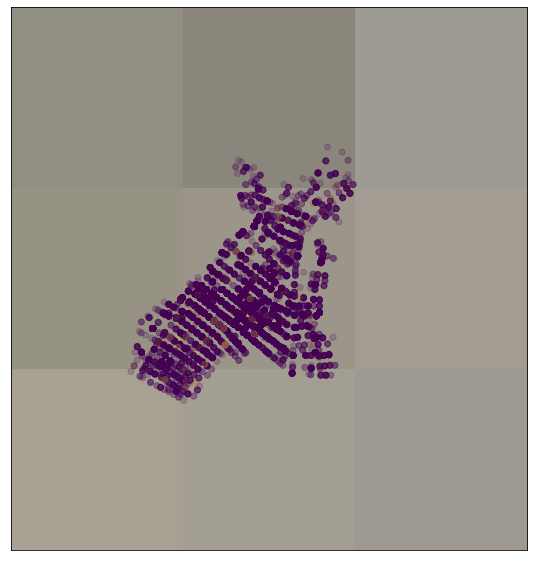

In [60]:
# Analyze Crimes in Area Central on a map - 2019: 

# Step 1: Define df with Crimes in Central 
central_2019 = crime.where(col("occ_year") == 2019)\
                .filter(col("area_name")=="Central")\
                .select("dr_no","area_","area_name","rpt_dist_no","location","lat","lon","crm_cd_1","Classification_1","Classification_2")\
                .cache()



# Step 2a: Define a function to get crime
def in_LA(longitude,latitude):
    # LA bounding box (aka bbox) from https://boundingbox.klokantech.com/
     # LA: westlimit=-118.668187; southlimit=33.703622; eastlimit=-118.155295; northlimit=34.337306
    return (longitude > -118.668187) & (longitude < -118.155295) & (latitude > 33.703622) & (latitude  < 34.337306) 

# Step 2b: Register UDF function
in_LA_udf = F.udf(in_LA,BooleanType()) 

# Step 3: Apply function on df
crime_locations = central_2019
crime_on_map = crime_locations.where(in_LA_udf(crime_locations.lon, crime_locations.lat))

# Step 4: Plotting the map

#import numpy as np
#import matplotlib.pyplot as plt
#import pandas as pd
import geopandas as gpd
from mpl_toolkits.basemap import Basemap

#df is now a Panda dataframe
df_map = crime_on_map.toPandas()

fig = plt.figure(figsize=(10, 10))

# centers the map in LA
# LA: 
m = Basemap(projection='lcc', resolution='h', lat_0=34.0522, lon_0=-118.2437, width=1.045E4, height=1.1E4) 

m.shadedrelief()
m.drawcoastlines(color='blue',linewidth=2)
m.drawcountries(color='black',linewidth=2)

lat=df_map['lat'].values
lon=df_map['lon'].values
#used for colors
colors=df_map['dr_no'].values
#used for sizing the dot
#sizing=100*df['hp'].values / df['total'].values

m.scatter(lon,lat,latlon=True,c=colors, alpha=0.2) #s=sizing,

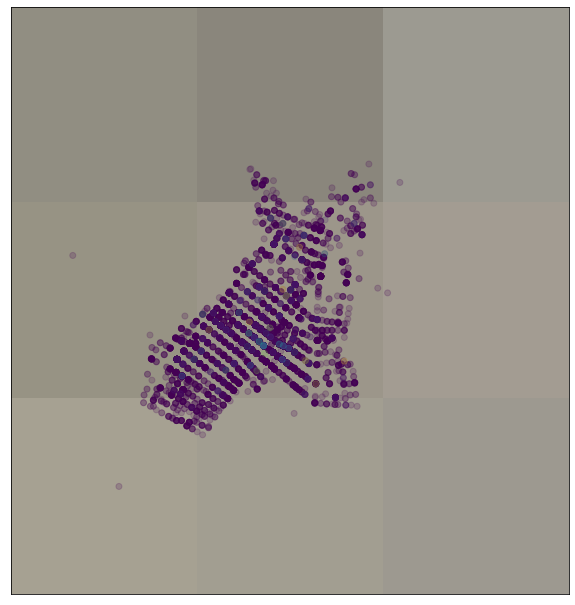

In [61]:
#Let's see if we can observe a visual difference between 2010 and 2019
# Analyze Crimes in Area Central on a map - 2010

# Step 1: Define df with Crimes in Central 
central_2010 = crime.where(col("occ_year") == 2010)\
                .filter(col("area_name")=="Central")\
                .select("dr_no","area_","area_name","rpt_dist_no","location","lat","lon","crm_cd_1","Classification_1","Classification_2")\
                .cache()

# Step 2: Define a function to get crime [DONE]

# Step 3: Apply function on df
crime_locations = central_2010
crime_on_map = crime_locations.where(in_LA_udf(crime_locations.lon, crime_locations.lat))

# Step 4: Plotting the map

#df is now a Panda dataframe
df_map = crime_on_map.toPandas()

fig = plt.figure(figsize=(10, 100))

# centers the map in LA
m = Basemap(projection='lcc', resolution='h', lat_0=34.0522, lon_0=-118.2437, width=1.045E4, height=1.1E4) 

m.shadedrelief()
m.drawcoastlines(color='blue',linewidth=2)
m.drawcountries(color='black',linewidth=2)

lat=df_map['lat'].values
lon=df_map['lon'].values
#used for colors
colors=df_map['dr_no'].values
#used for sizing the dot
#sizing=100*df['hp'].values / df['total'].values

m.scatter(lon,lat,latlon=True,c=colors, alpha=0.2) #s=sizing,

**Comment: the visualization of the map still needs some improvement, mainly regarding the resolution of the underlying basemap. (Suggestion: using arcgisimage with below code, once server becomes available again)**

map = Basemap(llcrnrlon=-118.5,llcrnrlat=33.15,urcrnrlon=-117.15,urcrnrlat=34.5, epsg=4269)
* http://server.arcgisonline.com/arcgis/rest/services
* EPSG Number of America is 4269

map.arcgisimage(server='https://server.arcgisonline.com/ArcGIS', service='ESRI_Imagery_World_2D', xpixels=2000, ypixels=None, dpi=96, verbose=True)

map.scatter(lon,lat,latlon=True,c=colors, alpha=0.5) #s=sizing,


#### 3.2 By type of location

In [62]:
crime.groupBy("premis_desc").pivot("occ_year").agg(F.count("dr_no"))\
        .withColumn("5y_abs_growth", round((col("2019")/col("2014")-1),2))\
        .withColumn("9y_abs_growth", round((col("2019")/col("2010")-1),2))\
        .orderBy(col("2019").desc())\
        .show(10,False)

+--------------------------------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------------+-------------+
|premis_desc                                 |2010 |2011 |2012 |2013 |2014 |2015 |2016 |2017 |2018 |2019 |5y_abs_growth|9y_abs_growth|
+--------------------------------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------------+-------------+
|STREET                                      |48554|44713|43441|41109|40757|46116|51428|54068|52377|50299|0.23         |0.04         |
|SINGLE FAMILY DWELLING                      |47262|45429|44066|41470|41107|42724|42604|42691|42308|39580|-0.04        |-0.16        |
|MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)|27399|26781|27784|26198|26457|27417|27017|26775|25828|24127|-0.09        |-0.12        |
|PARKING LOT                                 |13974|13126|13957|13817|13199|14947|16844|17084|17246|15741|0.19         |0.13         |
|SIDEWALK                                    |9773 |988

Over the past 5 years, there has been a decrease in crimes occurring in single- or in multi-family dwellings by 4%, respectively 9%, while in the same time frame Streets have become the location type with most crimes occurring (+23%). 

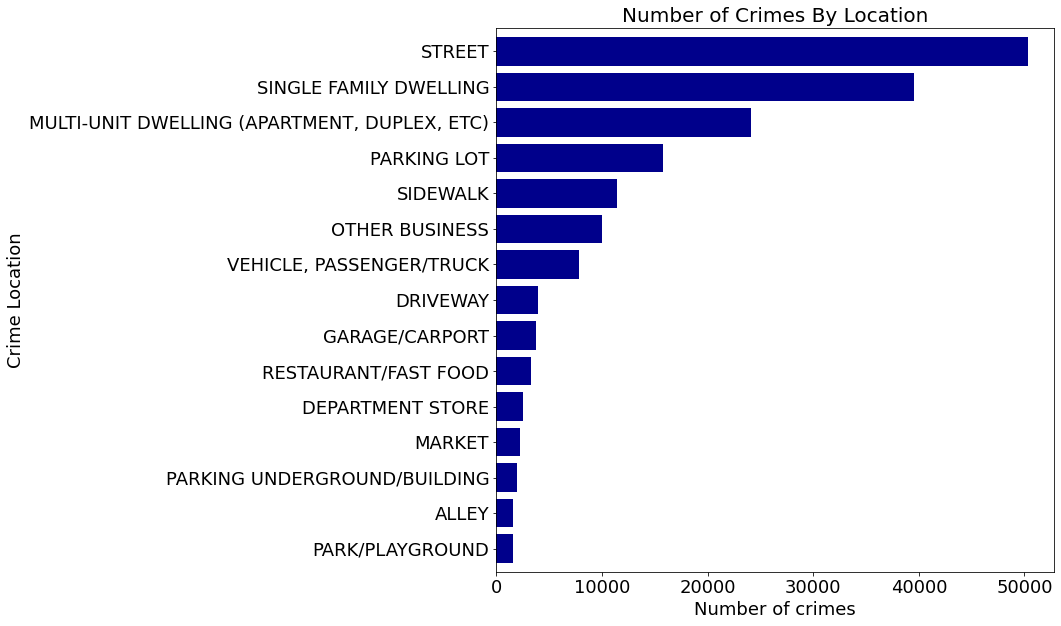

In [63]:
# Select 2019 and top15 Premises where crimes occur and save to Pandas DF
graph = crime.filter(col("occ_year")=="2019")\
            .groupBy("premis_desc").agg(F.count("dr_no").alias("count"))\
            .orderBy(col("count").desc())\
            .limit(15)\
            .toPandas()

# Plot
myplot = graph.plot(figsize = (10,10), kind = "barh", color = "darkblue", width = 0.8,
                               x = "premis_desc", y = "count", legend = False)
myplot.invert_yaxis()
plt.xlabel("Number of crimes", fontsize = 18)
plt.ylabel("Crime Location", fontsize = 18)
plt.title("Number of Crimes By Location", fontsize = 20)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

We can also assess what type of crimes are occuring in those locations most often: 

In [64]:
# Main Crimes occuring on the Street (2019)
crimes_street2019 = crime.filter(col("occ_year")=="2019").filter(col("premis_desc")=="STREET").count()

print("Main crimes on the street (2019):")
crime.filter(col("occ_year")=="2019")\
        .filter(col("premis_desc")=="STREET")\
        .groupBy("Classification_2")\
        .agg(F.count("dr_no").alias("count"))\
        .withColumn("% of 2019 crimes", round(col("count")/crimes_street2019,2))\
        .orderBy(col("count").desc())\
        .show(10,False)

Main crimes on the street (2019):
+----------------------------------+-----+----------------+
|Classification_2                  |count|% of 2019 crimes|
+----------------------------------+-----+----------------+
|BTFV                              |16922|0.34            |
|MVT (GTA)                         |11352|0.23            |
|Part II Crime                     |6172 |0.12            |
|Agg. Assault                      |3549 |0.07            |
|Simple Assault                    |3438 |0.07            |
|Robbery                           |2790 |0.06            |
|Simple Assault - Domestic Violence|2574 |0.05            |
|Other Theft                       |1595 |0.03            |
|Agg. Assault - Domestic Violence  |1176 |0.02            |
|Personal Theft                    |441  |0.01            |
+----------------------------------+-----+----------------+
only showing top 10 rows



In [65]:
# Main Crimes occuring in Single and Multi-family dwellings (2019)
crimes_dwellings2019 = crime.filter(col("occ_year")=="2019")\
        .filter((col("premis_desc")=="SINGLE FAMILY DWELLING") | (col("premis_desc")=="MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC")).count()

print("Main crimes in dwellings (2019):")
crime.filter(col("occ_year")=="2019")\
        .filter((col("premis_desc")=="SINGLE FAMILY DWELLING") | (col("premis_desc")=="MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC"))\
        .groupBy("Classification_2")\
        .agg(F.count("dr_no").alias("count"))\
        .withColumn("% of 2019 crimes", round(col("count")/crimes_dwellings2019,2))\
        .orderBy(col("count").desc())\
        .show(10,False)

print("Main crimes in dwellings, Part II Crimes (2019):")
crime.filter(col("occ_year")=="2019")\
        .filter((col("premis_desc")=="SINGLE FAMILY DWELLING") | (col("premis_desc")=="MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC"))\
        .filter(col("Classification_2")=="Part II Crime")\
        .groupBy("crm_cd_desc")\
        .agg(F.count("dr_no").alias("count"))\
        .withColumn("% of 2019 crimes", round(col("count")/crimes_dwellings2019,2))\
        .orderBy(col("count").desc())\
        .show(10,False)

Main crimes in dwellings (2019):
+----------------------------------+-----+----------------+
|Classification_2                  |count|% of 2019 crimes|
+----------------------------------+-----+----------------+
|Part II Crime                     |16513|0.42            |
|Simple Assault - Domestic Violence|6247 |0.16            |
|Burglary                          |5466 |0.14            |
|Other Theft                       |3688 |0.09            |
|Simple Assault                    |3212 |0.08            |
|Agg. Assault - Domestic Violence  |1612 |0.04            |
|Agg. Assault                      |1319 |0.03            |
|BTFV                              |545  |0.01            |
|Rape                              |493  |0.01            |
|Robbery                           |335  |0.01            |
+----------------------------------+-----+----------------+
only showing top 10 rows

Main crimes in dwellings, Part II Crimes (2019):
+---------------------------------------------------

### (4) When are crimes occuring

In the following, we will analyze which times of the year, of the week and of the day are the most active in terms of crimes happening.

##### Preparing dataset

In [66]:
# Get hour occured
# To do so, we will convert the time_occ to an actual time format by adding 0 to ensure we have 4 digits, extracting the hours (first 2 letters from the left),
# taking the same way minutes, and then concatenating the two to get the hour and minute per day. 
# Finally, we pad the hours with zeros on the right and drop the minutes since we don't need this variable anymore.

crime = crime.withColumn("time_occ",F.lpad(col("time_occ"),4,"0"))\
        .withColumn("hour_occ",substring("time_occ",0,2))\
        .withColumn("min_occ",substring("time_occ",3,4))\
        .withColumn("time_occ",concat_ws(":",col("hour_occ"),col("min_occ")))\
        .drop(col("min_occ"))\
        .withColumn("hour_occ",F.rpad(col("hour_occ"),4,"00"))

crime.select("time_occ","hour_occ").show()
crime.select("time_occ","hour_occ").dtypes

+--------+--------+
|time_occ|hour_occ|
+--------+--------+
|   13:50|    1300|
|   00:45|    0000|
|   15:15|    1500|
|   01:50|    0100|
|   21:00|    2100|
|   16:50|    1600|
|   20:05|    2000|
|   21:00|    2100|
|   02:30|    0200|
|   21:00|    2100|
|   14:45|    1400|
|   20:00|    2000|
|   02:45|    0200|
|   17:45|    1700|
|   20:30|    2000|
|   17:35|    1700|
|   12:25|    1200|
|   11:00|    1100|
|   20:00|    2000|
|   18:20|    1800|
+--------+--------+
only showing top 20 rows



[('time_occ', 'string'), ('hour_occ', 'string')]

#### 4.1 Time and Weekdays

<AxesSubplot:xlabel='hour_occ', ylabel='occ_dayofweek'>

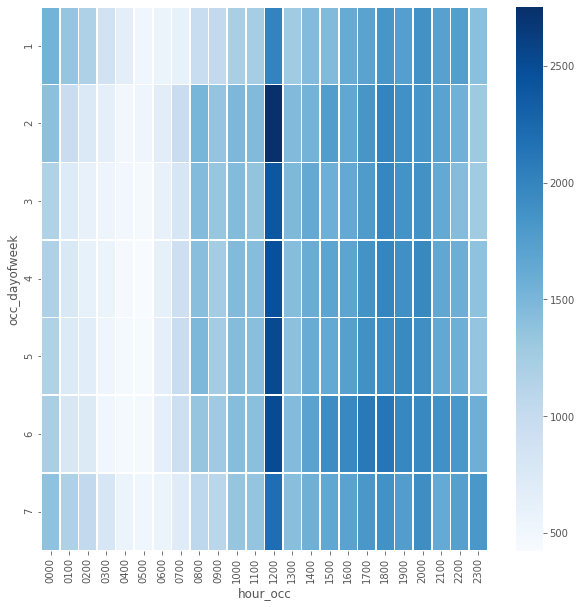

In [82]:
# We use a heatmap to detect which hours of the day of which weekdays the most crimes are occuring. 
# Daysofweek: 1=Sunday, 7=Saturday

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')

def count_rows(x):
    return len(x)

# Convert df to a Panda Dataframe
graph = crime.filter(col("occ_year")=="2018")\
            .select("occ_dayofweek","hour_occ")\
            .toPandas()

m = graph.groupby(["occ_dayofweek","hour_occ"]).apply(count_rows).unstack().sort_index()
plot.figsize = (10,10)
sns.heatmap(m, cmap='Blues', linewidth=0.5)

We observe that most crimes appear to be happening around noon.

In [68]:
# Analyzing which crimes occur mostly at this time
# Part I and Part II Crimes
crime.filter((col("hour_occ")=="1200") & (col("occ_year")=="2019"))\
        .groupBy("occ_dayofweek","Classification_2").agg(F.count("dr_no").alias("count"))\
        .orderBy(col("count").desc())\
        .show(30,False)

+-------------+----------------------------------+-----+
|occ_dayofweek|Classification_2                  |count|
+-------------+----------------------------------+-----+
|6            |Part II Crime                     |977  |
|3            |Part II Crime                     |976  |
|2            |Part II Crime                     |960  |
|4            |Part II Crime                     |887  |
|5            |Part II Crime                     |861  |
|7            |Part II Crime                     |660  |
|1            |Part II Crime                     |644  |
|6            |Other Theft                       |428  |
|4            |Other Theft                       |421  |
|2            |Other Theft                       |419  |
|3            |Other Theft                       |375  |
|5            |Other Theft                       |370  |
|7            |Other Theft                       |356  |
|1            |Other Theft                       |320  |
|7            |BTFV            

In [69]:
# Analyzing which crimes occur mostly at this time
# Part II Crimes
crime.filter((col("hour_occ")=="1200") & (col("occ_year")=="2019") & (col("Classification_1") == "Part II Crime"))\
        .groupBy("occ_dayofweek","crm_cd_desc").agg(F.count("dr_no").alias("count"))\
        .orderBy(col("count").desc())\
        .show(30,False)

+-------------+-------------------------------------------------------+-----+
|occ_dayofweek|crm_cd_desc                                            |count|
+-------------+-------------------------------------------------------+-----+
|6            |THEFT OF IDENTITY                                      |414  |
|2            |THEFT OF IDENTITY                                      |404  |
|3            |THEFT OF IDENTITY                                      |399  |
|4            |THEFT OF IDENTITY                                      |366  |
|5            |THEFT OF IDENTITY                                      |338  |
|1            |THEFT OF IDENTITY                                      |234  |
|7            |THEFT OF IDENTITY                                      |220  |
|4            |VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)|106  |
|1            |VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)|99   |
|3            |VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDA

While a bit difficult to read, we can still see that the crimes mostly occuring around noon are mostly Part II Crimes (Identify Theft, Vandalism, Document Forgery, ...) as well as thefts and burglaries from vehicles as well as Assault. The weekday seems to play little to no influence. However, it seems unlikely that those crimes are all committed during lunch time so we assume that either noon is being used as a placeholder if exact time is not known or an error occured during transciption. 
We will thus remove all crimes happening at noon to see if we can identify other patterns. 

Time of crime vs. weekday of crime (2019)


<AxesSubplot:xlabel='hour_occ', ylabel='occ_dayofweek'>

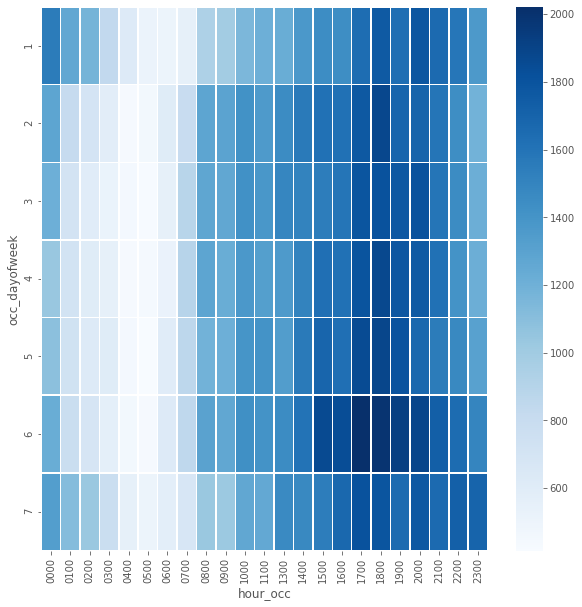

In [83]:
# Convert df to a Panda Dataframe
graph = crime.filter(col("occ_year")=="2019")\
            .filter(col("hour_occ")!=1200)\
            .select("occ_dayofweek","hour_occ")\
            .sort(col("occ_dayofweek").desc())\
            .toPandas()

print("Time of crime vs. weekday of crime (2019)")
m = graph.groupby(["occ_dayofweek","hour_occ"]).apply(count_rows).unstack().sort_index()
sns.heatmap(m, cmap='Blues', linewidth=0.5)

With the crimes reported as of happening at noon removed, we can now see a clear pattern which was not visible before: Crimes mostly occur during the later hours of the afternoon and early evening until 8pm with only little crime activity taking place in the very early morning hours. The heaviest crime activity is on Friday evenings around 5pm (mainly theft, burglary, battery, stolen vehicles, vandalism - see below)

In [71]:
# Check Friday evenings: 
print("Most frequent Crimes on Friday evenings, 5 pm")
crime.filter((col("hour_occ")=="1700") & (col("occ_dayofweek")==6) & (col("occ_year")=="2019"))\
        .groupBy("crm_cd_desc").agg(F.count("dr_no").alias("count"))\
        .orderBy(col("count").desc())\
        .show(15,False)


# Analyzing typical daytime and weekday by crime type (excluding crimes at noon)
print("Average daytime and weekday by crime type")
crime.filter((col("hour_occ")!="1200") & (col("occ_year")=="2019"))\
        .groupBy("Classification_2")\
        .agg((F.count("dr_no").alias("count")), (round(F.mean("hour_occ"),2).alias("Avg.hour")), (round(F.mean("occ_dayofweek"),2).alias("Avg.weekday")))\
        .orderBy(col("count").desc())\
        .show(15,False)


Most frequent Crimes on Friday evenings, 5 pm
+--------------------------------------------------------+-----+
|crm_cd_desc                                             |count|
+--------------------------------------------------------+-----+
|THEFT PLAIN - PETTY ($950 & UNDER)                      |178  |
|BURGLARY FROM VEHICLE                                   |166  |
|BATTERY - SIMPLE ASSAULT                                |158  |
|VEHICLE - STOLEN                                        |154  |
|BURGLARY                                                |151  |
|VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) |131  |
|THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)         |112  |
|ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT          |91   |
|VANDALISM - MISDEAMEANOR ($399 OR UNDER)                |78   |
|THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD|77   |
|ROBBERY                                                 |74   |
|SHOPLIFTING - PETTY THEFT ($950 & UNDER)   

#### 4.2 By time of the year

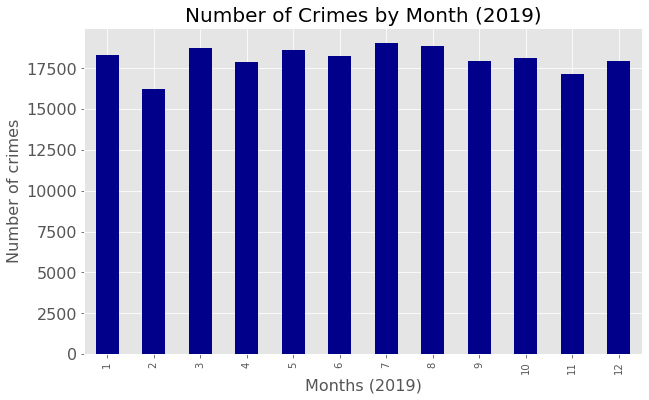

In [72]:
# Analyzing number of crimes throughout the year (2019):
# Convert df to a Panda Dataframe
graph = crime.filter(col("occ_year")=="2019").select("occ_year","occ_month","dr_no")\
            .groupBy("occ_month").agg(F.count("dr_no").alias("count"))\
            .orderBy(col("occ_month").asc())\
            .toPandas()


# Plot the Crime rate
graph.plot(figsize = (10,6), kind = "bar", color = "darkblue",
                               x = "occ_month", y = "count", legend = False)
plt.xlabel("Months (2019)", fontsize = 16)
plt.ylabel("Number of crimes", fontsize = 16)
plt.title("Number of Crimes by Month (2019)", fontsize = 20)
#plt.xticks(size = 16)
plt.yticks(size = 16)
plt.show()

### (5) How much time passes between a crime occuring and being reported

We will now have a look at how quickly crimes are being reported to the police after the crime has happened and which crimes typically are reported later:

##### Preparing the dataset

In [73]:
# Create new variable "Time until reporting"
crime = crime.withColumn("time_to_report", F.datediff("date_reported","date_occured"))   

crime.select("time_to_report","date_reported","date_occured").show(10)
crime.select("time_to_report","date_reported","date_occured").printSchema()

+--------------+-------------+------------+
|time_to_report|date_reported|date_occured|
+--------------+-------------+------------+
|             0|   2010-02-20|  2010-02-20|
|             1|   2010-09-13|  2010-09-12|
|             0|   2010-08-09|  2010-08-09|
|             0|   2010-01-05|  2010-01-05|
|             1|   2010-01-03|  2010-01-02|
|             1|   2010-01-05|  2010-01-04|
|             1|   2010-01-08|  2010-01-07|
|             1|   2010-01-09|  2010-01-08|
|             0|   2010-01-09|  2010-01-09|
|             3|   2010-01-09|  2010-01-06|
+--------------+-------------+------------+
only showing top 10 rows

root
 |-- time_to_report: integer (nullable = true)
 |-- date_reported: date (nullable = true)
 |-- date_occured: date (nullable = true)



##### Analyzing time to report a crime

In [92]:
# Time to report by year
print("Mean, min and max Time to report a crime:")
crime.groupBy("occ_year")\
        .agg((round(F.mean("time_to_report"),1).alias("Mean time to report")),(F.min("time_to_report").alias("Min time to report")),
             (F.max("time_to_report").alias("Max time to report")), (round(F.stddev("time_to_report"),1).alias("St.Deviation time to report")))\
        .orderBy("occ_year")\
        .show(10,False)

Mean, min and max Time to report a crime:
+--------+-------------------+------------------+------------------+---------------------------+
|occ_year|Mean time to report|Min time to report|Max time to report|St.Deviation time to report|
+--------+-------------------+------------------+------------------+---------------------------+
|2010    |34.2               |0                 |3988              |228.7                      |
|2011    |30.0               |0                 |3621              |192.5                      |
|2012    |26.8               |0                 |3265              |171.9                      |
|2013    |24.8               |0                 |2885              |155.5                      |
|2014    |22.7               |0                 |2533              |136.2                      |
|2015    |19.8               |0                 |2165              |116.8                      |
|2016    |15.9               |0                 |1803              |92.8             

We realize a few things: (1) on average crimes are being reported much later than when they occur, (2) The average time to report has been steadily decrasing in recent years, (3) Some crimes are not reported until several years later. This obviously influences mean values. 
Let's analyze how time to report differs for different crime types. 

In [75]:
# Time to report by crime Type (Classification 2)
print("Development of Time to report by Crime Types by year (based on Classification 2):")
crime.groupBy("Classification_2").pivot("occ_year").agg(round(F.mean("time_to_report"),1))\
        .orderBy(col("2019").desc())\
        .show(10,False)

# Time to report by crime Type (Classification 2), ordered by 5-year rate in reduction 
print("Development of Time to report by Crime Types by year (based on Classification 2):")
crime.groupBy("Classification_2").pivot("occ_year").agg(round(F.mean("time_to_report"),1))\
        .withColumn("5y_abs_growth", round((col("2019")/col("2014")-1),2))\
        .withColumn("9y_abs_growth", round((col("2019")/col("2010")-1),2))\
        .orderBy(col("5y_abs_growth").asc())\
        .show(15,False)

# Part II Crimes: Time to report by crime Type 
print("Part II Crimes: Development of Time to report by Crime Types by year (based on Classification 2):")
crime.filter(col("Classification_2")=="Part II Crime")\
        .groupBy("crm_cd_desc").pivot("occ_year").agg(round(F.mean("time_to_report"),1))\
        .orderBy(col("2019").desc())\
        .show(10,False)

Development of Time to report by Crime Types by year (based on Classification 2):
+----------------------------------+-----+-----+-----+-----+-----+-----+-----+----+----+----+
|Classification_2                  |2010 |2011 |2012 |2013 |2014 |2015 |2016 |2017|2018|2019|
+----------------------------------+-----+-----+-----+-----+-----+-----+-----+----+----+----+
|Rape                              |365.5|406.6|311.8|307.5|243.7|168.4|123.3|83.0|66.6|41.3|
|Part II Crime                     |85.9 |79.1 |67.3 |62.8 |54.4 |47.7 |39.1 |32.4|24.2|17.3|
|Other Theft                       |21.9 |16.9 |15.7 |13.5 |14.1 |13.2 |11.5 |11.3|9.9 |7.8 |
|Burglary                          |12.0 |8.0  |8.4  |8.7  |8.4  |9.2  |7.5  |7.9 |7.5 |7.0 |
|Simple Assault - Domestic Violence|13.3 |8.8  |10.4 |10.2 |10.3 |8.7  |7.5  |7.3 |6.3 |4.6 |
|Homicide                          |1.8  |0.8  |1.9  |9.3  |1.0  |11.0 |5.2  |0.4 |1.3 |4.6 |
|MVT (GTA)                         |11.0 |5.7  |7.3  |5.9  |6.2  |6.4  |

We can see that especially rape and Part II Crimes (related to sexual offenses, crimes against children, etc.) are being reported much later than other crime types. Overall, in the past 5 and 9 years  time to report has been significantly decreasing across all categories, especially notable for rape, with one exception: homicides.

We can also explore the extend of late reporting visually: 

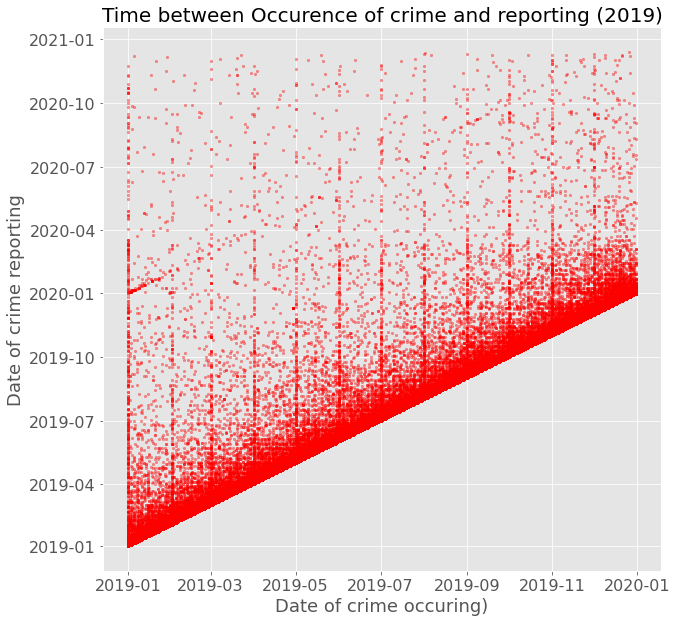

In [84]:
# Draw a scatter plot of time crime occures (2019) vs. time until crime is being reported
import numpy as np
# Convert df to a Panda Dataframe
plot = crime.filter(col("occ_year")==2019)\
            .select("date_occured","date_reported","Classification_2")\
            .orderBy("date_reported")\
            .toPandas()


# Create data
x = plot["date_occured"]
y = plot["date_reported"]
area = np.pi*2

# Create plot
plt.scatter(x, y, s = area, alpha=0.4, color="red")
plt.title("Time between Occurence of crime and reporting (2019)", fontsize = 20)
#plt.legend(loc=2)
plt.xlabel("Date of crime occuring)", fontsize = 18)
plt.ylabel("Date of crime reporting", fontsize = 18)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.show()

## Part III: Saving Results

We have come to the end of our analysis, finally, and will save the key results of our analysis so they can be reused for further analysis:

In [87]:
crime.printSchema()

root
 |-- crm_cd: integer (nullable = true)
 |-- dr_no: integer (nullable = true)
 |-- date_rptd: string (nullable = true)
 |-- date_occ: string (nullable = true)
 |-- time_occ: string (nullable = false)
 |-- area_: integer (nullable = true)
 |-- area_name: string (nullable = true)
 |-- rpt_dist_no: integer (nullable = true)
 |-- part_1-2: integer (nullable = true)
 |-- crm_cd_desc: string (nullable = true)
 |-- vict_age: integer (nullable = true)
 |-- vict_sex: string (nullable = false)
 |-- vict_descent: string (nullable = false)
 |-- premis_cd: integer (nullable = true)
 |-- premis_desc: string (nullable = false)
 |-- weapon_used_cd: integer (nullable = true)
 |-- weapon_desc: string (nullable = false)
 |-- status: string (nullable = false)
 |-- status_desc: string (nullable = false)
 |-- crm_cd_1: integer (nullable = true)
 |-- crm_cd_2: integer (nullable = true)
 |-- crm_cd_3: integer (nullable = true)
 |-- crm_cd_4: integer (nullable = true)
 |-- location: string (nullable = true

In [93]:
# Save crime dataframe in parquet format
crime.write.parquet("crime_LA/parquet/")

# Save crime_rate dataframe in parquet format
crime_rate.write.parquet("crime_rate_LA/parquet/")

# Save age_categories dataframe in parquet format
age_categories.write.parquet("age_categories_LA/parquet/")